## Training UNet model for fire scar prediction 


In [1]:
### from scratch
# Getting normalization stats
import os
import glob
import rasterio
import numpy as np

merged_dir = 'data/merged'
merged_files = sorted(glob.glob(os.path.join(merged_dir, 'merged_ID*.tif')))

band_count = None
band_names = []
global_sum = []
global_sum_sq = []
global_pixel_count = []

for merged_path in merged_files:
    with rasterio.open(merged_path) as src:
        if band_count is None:
            band_count = src.count
            band_names = list(src.descriptions) if src.descriptions else [f'Band {i+1}' for i in range(band_count)]
            global_sum = [0.0] * band_count
            global_sum_sq = [0.0] * band_count
            global_pixel_count = [0] * band_count
        
        for i in range(1, band_count + 1):
            band = src.read(i).astype(np.float32)
            nodata = src.nodata
            if nodata is not None:
                band[band == nodata] = np.nan

            valid_pixels = ~np.isnan(band)
            band_valid = band[valid_pixels]

            if band_valid.size > 0:
                idx = i - 1
                global_sum[idx] += np.nansum(band_valid)
                global_sum_sq[idx] += np.nansum(band_valid**2)
                global_pixel_count[idx] += band_valid.size

global_mean = [s / c if c > 0 else np.nan for s, c in zip(global_sum, global_pixel_count)]
global_std = [
    np.sqrt((sq / c) - (m ** 2)) if c > 0 else np.nan
    for sq, c, m in zip(global_sum_sq, global_pixel_count, global_mean)
]

print("Global Mean and Std per Band:")
for i in range(band_count):
    print(f"{band_names[i]}: mean={global_mean[i]:.4f}, std={global_std[i]:.4f}")


Global Mean and Std per Band:
Ignition Point: mean=0.0000, std=0.0001
Distance to Water: mean=5813.8086, std=3816.9896
Heat Load: mean=0.5343, std=0.3222
Topographic Complexity: mean=2.2723, std=2.1330
Slope: mean=7.2479, std=8.2621
Elevation: mean=358.5952, std=388.9895
Aspect: mean=199.6984, std=92.1633
NDVI: mean=0.4463, std=0.1693
Fire History: mean=0.0016, std=0.0107
Time Since Last Fire: mean=32.2916, std=4.2432
Max Temperature Anomaly: mean=0.1813, std=0.8588
Minimum Temperature Anomaly: mean=0.1772, std=0.7127
Precipitation Anomaly: mean=-0.8084, std=16.6210
Accumulated Annual Precipitation: mean=397.8843, std=374.9523
Solar Radiation: mean=24350.4528, std=8524.3556
Water Vapor Pressure: mean=1.2697, std=0.1793
Wind Speed: mean=2.4683, std=0.4378
Distance to Road: mean=1514.8222, std=2101.6571
Distance to Population: mean=10193.7952, std=9285.8278
Population Density: mean=42.7422, std=101.3608


In [2]:
# Create PyTorch Dataset
import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define augmentation pipeline for training
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
], additional_targets={'mask': 'mask'})

# For validation/test, no augmentation except conversion to tensor
val_transform = A.Compose([], additional_targets={'mask': 'mask'})


class FireDataset(Dataset):
    def __init__(self, merged_dir, mask_dir, band_mean, band_std, transform=None):
        self.merged_dir = merged_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        self.ids = [f.split('_')[-1] for f in os.listdir(merged_dir) if f.startswith('merged_')]
        
        self.band_mean = torch.tensor(band_mean).view(-1, 1, 1)
        self.band_std = torch.tensor(band_std).view(-1, 1, 1)
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id_ = self.ids[idx]
        merged_path = os.path.join(self.merged_dir, f'merged_{id_}')
        mask_path = os.path.join(self.mask_dir, f'mask_{id_}')
        
        with rasterio.open(merged_path) as src:
            merged = src.read().astype(np.float32)  # (bands, H, W)
            nodata = src.nodata
            if nodata is not None:
                merged[merged == nodata] = np.nan
        
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)  # single band mask
        
        # Prepare for albumentations: (H, W, bands)
        merged = np.nan_to_num(merged, nan=0).transpose(1, 2, 0)
        
        # Apply augmentation
        if self.transform:
            augmented = self.transform(image=merged, mask=mask)
            merged = augmented['image']
            mask = augmented['mask']
        
        # Normalize bands and convert to tensor (C,H,W)
        merged = (merged - self.band_mean.numpy().transpose(1, 2, 0)) / self.band_std.numpy().transpose(1, 2, 0)
        merged = torch.tensor(merged.transpose(2, 0, 1), dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # add channel dim
        
        # Binarize mask just in case
        mask = (mask > 0).float()
        
        return merged, mask


/Users/abbystokes/anaconda3/envs/geoai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [3]:

##### Making smaller images (128 by 128)
from torch.utils.data import Dataset
import torch
import math

def tile_tensor(img, mask, patch_size=128, stride=128, threshold=0.0):
    tiles = []
    _, H, W = img.shape
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            img_patch = img[:, i:i+patch_size, j:j+patch_size]
            mask_patch = mask[:, i:i+patch_size, j:j+patch_size]
            
            if mask_patch.sum().item() / mask_patch.numel() > threshold:
                tiles.append((img_patch, mask_patch))
    return tiles

import torchvision.transforms.functional as TF
import random

def patch_transform(image, mask):
    # Random horizontal flip
    if random.random() > 0.5:
        image = TF.hflip(image)
        mask = TF.hflip(mask)
    
    # Random vertical flip
    if random.random() > 0.5:
        image = TF.vflip(image)
        mask = TF.vflip(mask)
    
    # Random rotation (0, 90, 180, 270 degrees)
    angle = random.choice([0, 90, 180, 270])
    image = TF.rotate(image, angle)
    mask = TF.rotate(mask, angle)

    return image, mask


class FirePatchDataset(Dataset):
    def __init__(self, base_dataset, patch_size=128, stride=128, threshold=0.0, transform=None):
        self.tiles = []
        self.transform = transform
        for idx in range(len(base_dataset)):
            img, mask = base_dataset[idx]
            tile_list = tile_tensor(img, mask, patch_size, stride, threshold)
            for img_tile, mask_tile in tile_list:
                if self.transform:
                    img_tile, mask_tile = self.transform(img_tile, mask_tile)
                self.tiles.append((img_tile, mask_tile))

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        return self.tiles[idx]


In [4]:
# Train test split, data loaders
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split

full_dataset = FireDataset('data/merged', 'data/mask', global_mean, global_std, transform=None)
patch_dataset = FirePatchDataset(full_dataset, patch_size=128, stride=64, threshold=0.01)

train_size = int(0.8 * len(patch_dataset))
val_size = len(patch_dataset) - train_size
train_dataset, val_dataset = random_split(patch_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [5]:
print(f"Train set size: {len(train_dataset)} samples")
print(f"Test set size: {len(val_dataset)} samples")


Train set size: 4348 samples
Test set size: 1087 samples


In [6]:
# Sanity check - normalization worked on small sample (n=30)
loader = DataLoader(patch_dataset, batch_size=30, shuffle=True)
batch_merged, batch_mask = next(iter(loader))

print("Per-band mean (batch):", batch_merged.mean(dim=[0,2,3]))
print("Per-band std (batch):", batch_merged.std(dim=[0,2,3]))


Per-band mean (batch): tensor([ 0.1639,  0.0436, -0.0706,  0.3123,  0.3444,  0.4204, -0.0904,  0.0458,
        -0.0319,  0.0437,  0.1711,  0.0008,  0.2429, -0.0902,  0.0926, -0.3401,
         0.3148,  0.7162,  0.3905, -0.1413])
Per-band std (batch): tensor([1.8500, 0.9644, 1.0137, 1.2385, 1.2693, 1.3638, 1.0143, 0.9974, 0.6867,
        0.9265, 0.7079, 0.8779, 1.7373, 0.9495, 1.1802, 1.3768, 0.9620, 2.3801,
        1.3795, 0.1980])


In [12]:
#### Models ######

# CNN Segmentation Net
import torch.nn as nn
import torch.nn.functional as F

class SimpleSegmentationCNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)  
        return x
    

class DeeperSegmentationCNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 1, kernel_size=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)  
        return x
    
# UNet
class UNet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)  # 128 -> 64

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)  # 64 -> 32

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)  # 32 -> 64
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)  # 64 -> 128
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)             # -> [B, 64, H, W]
        e2 = self.enc2(self.pool1(e1))# -> [B, 128, H/2, W/2]
        b = self.bottleneck(self.pool2(e2))  # -> [B, 256, H/4, W/4]
        
        u2 = self.up2(b)              # -> [B, 128, H/2, W/2]
        u2 = self._crop_and_concat(e2, u2)
        d2 = self.dec2(u2)

        u1 = self.up1(d2)             # -> [B, 64, H, W]
        u1 = self._crop_and_concat(e1, u1)
        d1 = self.dec1(u1)

        return self.final(d1)

    def _crop_and_concat(self, enc_feat, upsampled):
        # Crop enc_feat to match upsampled size (needed if odd input dims)
        if enc_feat.size()[2:] != upsampled.size()[2:]:
            enc_feat = TF.center_crop(enc_feat, upsampled.shape[2:])
        return torch.cat([upsampled, enc_feat], dim=1)
    


class UNetWithFeatures(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)             # shape [B, 64, H, W]
        e2 = self.enc2(self.pool1(e1))# shape [B, 128, H/2, W/2]
        b = self.bottleneck(self.pool2(e2))  # shape [B, 256, H/4, W/4]

        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        out = self.final(d1)
        return out, e1, e2, b  # return feature maps for visualization


In [17]:
from torchsummary import summary

model = UNetWithFeatures(in_channels=20).to('cuda' if torch.cuda.is_available() else 'cpu')
summary(model, input_size=(20, 128, 128))  # (channels, H, W)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          11,584
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [24]:
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Model, optimizer, loss
model = UNetWithFeatures(in_channels=band_count).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2) # try larger
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Weighted BCE loss
pos_weight = torch.tensor([10.0], device=device)  # Adjust as needed
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training config
num_epochs = 100
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for inputs, masks in train_loader:
        inputs = inputs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs, e1, e2, b = model(inputs)   # unpack tuple here
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, masks in val_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)
            outputs, e1, e2, b = model(inputs)   # unpack tuple here
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    # Learning rate scheduler step
    scheduler.step(avg_val_loss)

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")


/Users/abbystokes/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 - Train Loss: 3.4767 - Val Loss: 1.4011
Epoch 2/100 - Train Loss: 1.3439 - Val Loss: 1.3426
Epoch 3/100 - Train Loss: 1.2769 - Val Loss: 1.2811
Epoch 4/100 - Train Loss: 1.2445 - Val Loss: 1.2580
Epoch 5/100 - Train Loss: 1.2176 - Val Loss: 1.2711
Epoch 6/100 - Train Loss: 1.2040 - Val Loss: 1.2125
Epoch 7/100 - Train Loss: 1.1854 - Val Loss: 1.2000
Epoch 8/100 - Train Loss: 1.1798 - Val Loss: 1.2038
Epoch 9/100 - Train Loss: 1.1678 - Val Loss: 1.2046
Epoch 10/100 - Train Loss: 1.1558 - Val Loss: 1.1832
Epoch 11/100 - Train Loss: 1.1516 - Val Loss: 1.1784
Epoch 12/100 - Train Loss: 1.1512 - Val Loss: 1.2394
Epoch 13/100 - Train Loss: 1.1457 - Val Loss: 1.1947
Epoch 14/100 - Train Loss: 1.1443 - Val Loss: 1.1567
Epoch 15/100 - Train Loss: 1.1409 - Val Loss: 1.1964
Epoch 16/100 - Train Loss: 1.1363 - Val Loss: 1.1765
Epoch 17/100 - Train Loss: 1.1311 - Val Loss: 1.1995
Epoch 18/100 - Train Loss: 1.1283 - Val Loss: 1.1576
Epoch 19/100 - Train Loss: 1.0929 - Val Loss: 1.1463
Ep

KeyboardInterrupt: 

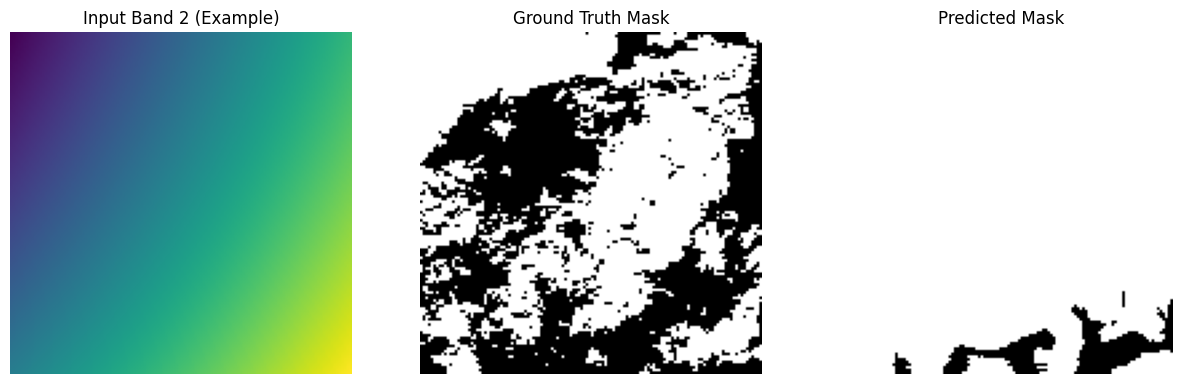

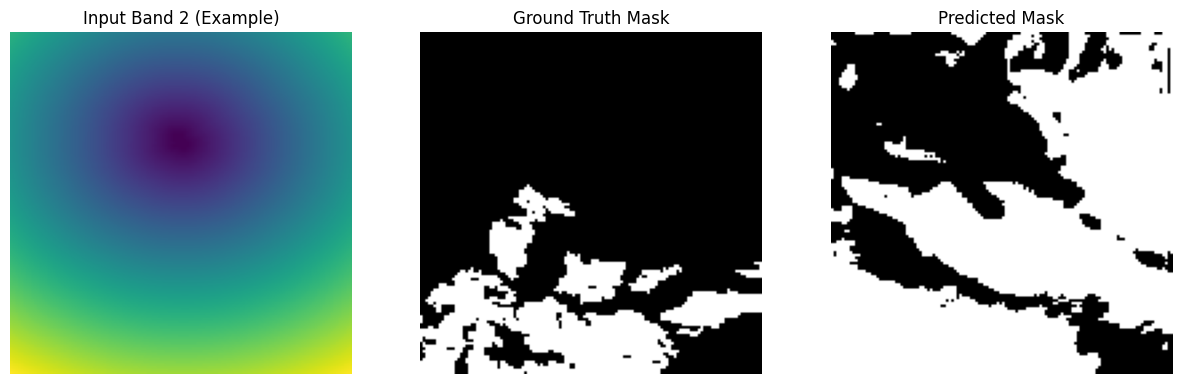

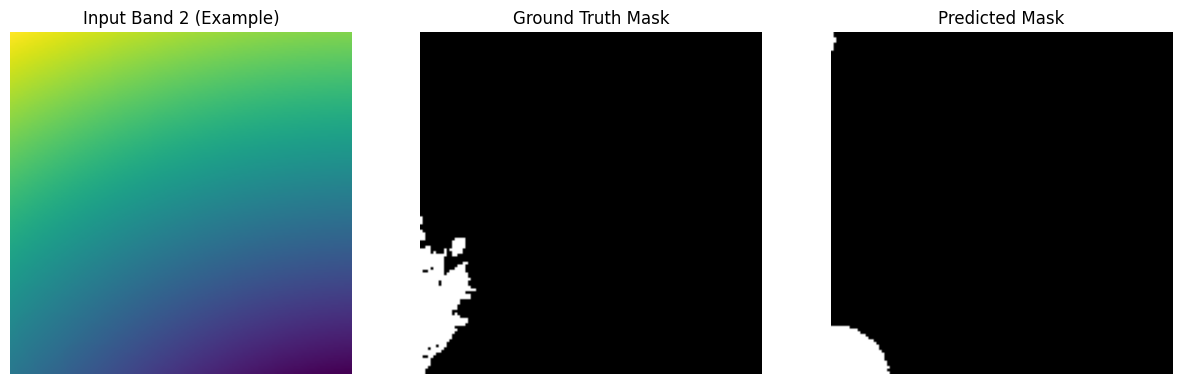

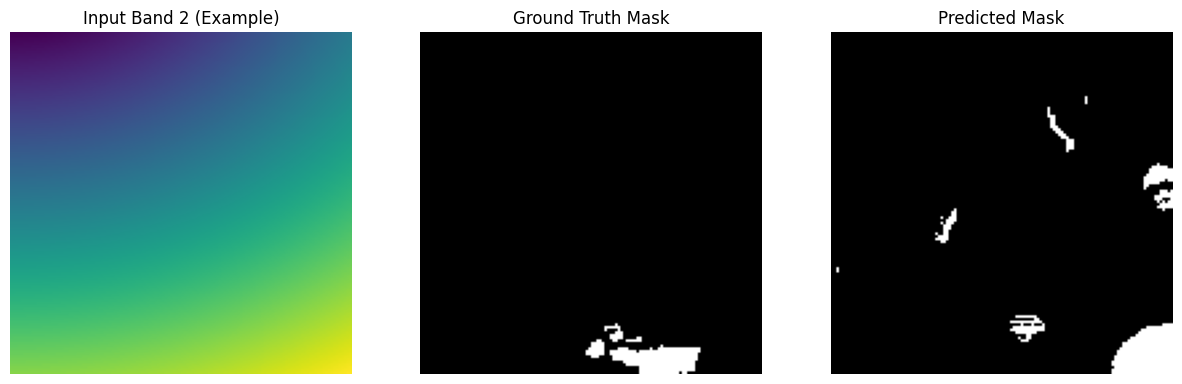

In [25]:
# Visualize prediction
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device, num_samples=4):
    model.eval()
    inputs, masks = next(iter(dataloader))
    inputs = inputs.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]       # raw logits
        probs = torch.sigmoid(outputs)   # scale to [0, 1]
        preds = (probs > 0.5).float()    # binary mask
    inputs = inputs.cpu()
    masks = masks.cpu()
    preds = preds.cpu()
    
    for i in range(min(num_samples, inputs.size(0))):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(inputs[i, 1], cmap='viridis')  # show first band as example
        axs[0].set_title('Input Band 2 (Example)')
        axs[0].axis('off')
        
        axs[1].imshow(masks[i, 0], cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')
        
        axs[2].imshow(preds[i, 0], cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')
        
        plt.show()

visualize_predictions(model, val_loader, device)



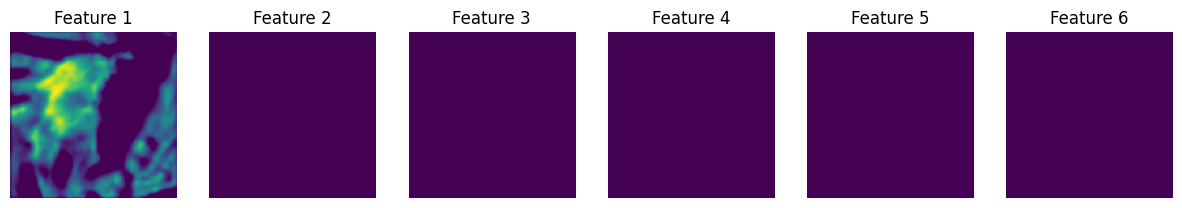

In [26]:
# Visualize feature maps
import matplotlib.pyplot as plt

model.eval()
inputs, _ = next(iter(val_loader))  # take a batch from validation set
inputs = inputs.to(device)

with torch.no_grad():
    outputs, e1, e2, b = model(inputs)

# Choose the first image in batch
feat_maps = e1[0]  # shape: [64, H, W]

# Plot some of the feature maps (e.g. first 6)
num_features_to_show = 6
fig, axs = plt.subplots(1, num_features_to_show, figsize=(15, 5))
for i in range(num_features_to_show):
    axs[i].imshow(feat_maps[i].cpu(), cmap='viridis')
    axs[i].axis('off')
    axs[i].set_title(f'Feature {i+1}')
plt.show()

In [27]:
#### Model Evaluation ####

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def iou_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=[1,2,3])
    union = (preds + targets).clamp(0,1).sum(dim=[1,2,3])
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def dice_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=[1,2,3])
    dice = (2 * intersection + eps) / (preds.sum(dim=[1,2,3]) + targets.sum(dim=[1,2,3]) + eps)
    return dice.mean().item()

def pixel_accuracy(preds, targets):
    correct = (preds == targets).float().sum()
    total = torch.numel(preds)
    return (correct / total).item()

model.eval()
ious = []
dices = []
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        probs = torch.sigmoid(outputs)  # convert to probabilities
        preds = (probs > 0.5).float()   # binarize predictions

        # Collect per-batch scores
        ious.append(iou_score(preds, targets))
        dices.append(dice_score(preds, targets))

        # Flatten predictions and targets for sklearn metrics
        all_preds.append(preds.view(-1).cpu())
        all_targets.append(targets.view(-1).cpu())
        all_probs.append(probs.view(-1).cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()
all_probs = torch.cat(all_probs).numpy()

# Sklearn metrics
roc_auc = roc_auc_score(all_targets, all_probs)
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds)
pixel_acc = (all_preds == all_targets).sum() / len(all_targets)

# Print all metrics
print(f"Validation IoU: {sum(ious)/len(ious):.4f}")
print(f"Validation Dice Score: {sum(dices)/len(dices):.4f}")
print(f"Validation Pixel Accuracy: {pixel_acc:.4f}")
print(f"Validation ROC AUC: {roc_auc:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")


Validation IoU: 0.1884
Validation Dice Score: 0.2782
Validation Pixel Accuracy: 0.6503
Validation ROC AUC: 0.8433
Validation Precision: 0.2427
Validation Recall: 0.8603
Validation F1 Score: 0.3786
